In [ ]:
#Reinitialize the Python interpreter, clearing all variables and imports
#%reset -f

*Configuración global de entorno*

In [2]:
from utils.preprocessing import preprocess_text
from utils.metrics import report_classification, plot_confusion
from utils.model_utils import tune_logistic_C
from utils.visualization import plot_decision_boundary


In [3]:
# Núcleo científico
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,4)

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Rutas para importar utils/
import sys, os
sys.path.append(os.path.abspath(".."))

# Utils del proyecto
from utils.preprocessing import preprocess_text
from utils.metrics import report_classification, plot_confusion
from utils.model_utils import tune_logistic_C

# NLTK (ya gestionado en utils, pero por si acaso…)
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("Entorno listo.")


Entorno listo.


# Parte A — Binary Classification on Text Data (Disaster Tweets)

**Objetivo:** Predecir si un tweet trata sobre un desastre real (`target=1`) o no (`target=0`) usando:
1) Carga y split (70/30 estratificado) y porcentajes de clases.  
2) Preprocesamiento de texto (lowercase, lemmatize/stem, quitar puntuación, stopwords, `@` y URLs).  
3) **Bag of Words binario** con `CountVectorizer(binary=True, min_df=M)` (ajuste **solo** en train).  
4) **Logistic Regression**: sin regularización, con L1 (selección de C), con L2 (selección de C).  
   - Reportar F1 en train/test, discutir over/underfitting, y **palabras más importantes (L1)**.  
5) **Bernoulli Naive Bayes** (implementación propia) con **Laplace α=1**; F1 train/test.  
6) **N-grams (2-gramas)**: vocabulario con `min_df=M2`, 10 ejemplos, LR+NB y comparación con BoW.


## PASO 1-Carga del dataset y split 70/30 estratificado

### 1) Data Loading and Splitting

- **Dataset:** `data/disaster_tweets.csv`.  
- **Variables relevantes:** `text` (X) y `target` (y).  
- **Validaciones aplicadas:**  
  - Columnas esperadas presentes (`id`, `text`, `location`, `keyword`, `target`).  
  - `target` coaccionado a entero y validado en {0,1}.  
  - Se filtran filas con `text` vacío o solo espacios (además de `NaN`).  
- **Reporte solicitado:** % de `target=1` (desastre real) y `target=0` (no).  
- **Split:** 70/30 **estratificado** para preservar proporción de clases.

In [4]:
from pathlib import Path

DATA_PATH = Path("..") / "data" / "disaster_tweets.csv"

# 1) Cargar
df = pd.read_csv(DATA_PATH)



In [5]:
# 2) Validar columnas
expected_cols = {"id", "text", "location", "keyword", "target"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")

In [6]:
# 3) Coerción y validación de target
df = df.copy()
df["target"] = pd.to_numeric(df["target"], errors="coerce")
if df["target"].isna().any():
    raise ValueError("Se encontraron valores no numéricos en 'target'.")
vals = set(df["target"].unique())
if not vals.issubset({0,1}):
    raise ValueError(f"'target' contiene valores fuera de {{0,1}}: {vals}")
df["target"] = df["target"].astype(int)



In [7]:
# 4) Limpiar text vacío/whitespace
df["text"] = df["text"].astype(str)
mask_nonempty = df["text"].str.strip().astype(bool)
empty_count = (~mask_nonempty).sum()
if empty_count > 0:
    print(f"Filtrando {empty_count} filas con 'text' vacío o solo espacios.")
df = df[mask_nonempty].reset_index(drop=True)

print("Shape final tras limpieza mínima:", df.shape)


Shape final tras limpieza mínima: (7613, 5)


In [8]:
# 5) % de clases
class_counts = df["target"].value_counts().sort_index()
class_pct = (class_counts / len(df) * 100).round(2)
display(pd.DataFrame({"count": class_counts, "pct_%": class_pct}))
print(f"\n% Real disaster (1): {class_pct.get(1,0.0)}%")
print(f"% No disaster (0):  {class_pct.get(0,0.0)}%")


,count,pct_%
target,,
0,4342,57.03
1,3271,42.97



% Real disaster (1): 42.97%
% No disaster (0):  57.03%


In [9]:
# 6) Split estratificado 70/30
X_raw = df["text"].values
y = df["target"].values

if np.min(np.bincount(y)) < 2:
    raise ValueError("Muy pocos ejemplos en la clase minoritaria — no se puede estratificar 70/30.")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

def pct(yv):
    return (pd.Series(yv).value_counts(normalize=True).sort_index() * 100).round(2)

print("\nTamaños — Train:", len(X_train_raw), "Test:", len(X_test_raw))
print("\n% Clases total:\n", pct(y))
print("\n% Clases train:\n", pct(y_train))
print("\n% Clases test:\n", pct(y_test))


Tamaños — Train: 5329 Test: 2284

% Clases total:
 0    57.03
1    42.97
Name: proportion, dtype: float64

% Clases train:
 0    57.03
1    42.97
Name: proportion, dtype: float64

% Clases test:
 0    57.05
1    42.95
Name: proportion, dtype: float64


## 2) Preprocesamiento y Bag of Words (binary)

### 2) Preprocesamiento y Bag of Words (binary)

**Decisiones y razones:**
- *lowercase* → homogeneiza tokens.  
- *lemmatize* → reduce variación morfológica (e.g., *floods*→*flood*).  
- quitar **puntuación/stopwords/URLs/@** → remueve ruido no informativo.  
- conservar palabras de hashtags (quitando `#`) → `#earthquake` → `earthquake`.  

**Vectorización:**
- `CountVectorizer(binary=True)` → presencia/ausencia (coherente con BoW binario).  
- `min_df = M` (filtra términos raros). Criterio robusto: `M = max(2, ceil(0.005 * n_docs_train))` (~0.5% del train).  
- **Ajuste solo con train** y reutilización para test (requisito del enunciado).


In [10]:
import nltk

# Verifica y descarga solo si faltan los recursos
for resource in ['punkt', 'punkt_tab', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{resource}') if 'punkt' in resource else nltk.data.find(f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
from math import ceil

# Preprocesamiento
X_train_clean = [preprocess_text(t) for t in X_train_raw]
X_test_clean  = [preprocess_text(t) for t in X_test_raw]

print("Ejemplo preprocesado:")
for i in range(2):
    print("RAW:", X_train_raw[i])
    print("CLEAN:", X_train_clean[i])
    print("---")

# Vectorización BoW (binaria)
n_train_docs = len(X_train_clean)
M = max(2, ceil(0.005 * n_train_docs))  # ~0.5% del train

vectorizer = CountVectorizer(binary=True, min_df=M)
X_train_bow = vectorizer.fit_transform(X_train_clean)   # fit SOLO en train
X_test_bow  = vectorizer.transform(X_test_clean)        # transform en test

vocab = vectorizer.get_feature_names_out()
print("Tamaño del vocabulario (BoW):", len(vocab))


Ejemplo preprocesado:
RAW: Las Vegas in top 5 cities for red-light running fatalities http://t.co/kC8O81BcHG
CLEAN: la vega top 5 city redlight running fatality
---
RAW: Do you feel like you are sinking in unhappiness? Take the quiz: http://t.co/BTjPEO0Bto http://t.co/ClyJ32L333
CLEAN: feel like sinking unhappiness take quiz
---
Tamaño del vocabulario (BoW): 292


## 3) Logistic Regression (None, L1, L2) — F1 train/test (Markdown)

### 3) Logistic Regression — evaluación con F1

Entrenamos:
1) **Sin regularización** (`penalty=None`).  
2) **L1** con selección de `C` por CV (5-fold).  
3) **L2** con selección de `C` por CV (5-fold).  

**Se reporta** F1 en *train/test*, se discute **over/underfitting** y se inspeccionan **palabras más importantes** del modelo L1.


3.1) Sin regularización (Código)


--- LR sin regularización — Train ---
Accuracy: 0.782
F1-score: 0.726
              precision    recall  f1-score   support

           0      0.778     0.865     0.819      3039
           1      0.790     0.672     0.726      2290

    accuracy                          0.782      5329
   macro avg      0.784     0.769     0.773      5329
weighted avg      0.783     0.782     0.779      5329



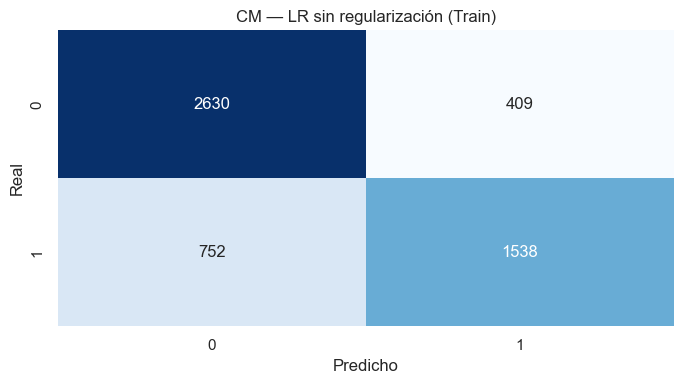


--- LR sin regularización — Test ---
Accuracy: 0.761
F1-score: 0.698
              precision    recall  f1-score   support

           0      0.760     0.849     0.802      1303
           1      0.762     0.643     0.698       981

    accuracy                          0.761      2284
   macro avg      0.761     0.746     0.750      2284
weighted avg      0.761     0.761     0.757      2284



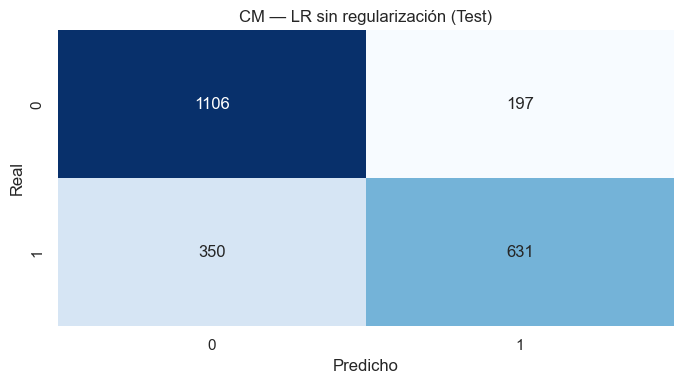


Resumen F1 — sin reg: train=0.7260  test=0.6976


In [13]:
lr_none = LogisticRegression(penalty=None, max_iter=400, random_state=RANDOM_STATE)
lr_none.fit(X_train_bow, y_train)

yhat_tr_none = lr_none.predict(X_train_bow)
yhat_te_none = lr_none.predict(X_test_bow)

f1_tr_none = f1_score(y_train, yhat_tr_none)
f1_te_none = f1_score(y_test,  yhat_te_none)

report_classification(y_train, yhat_tr_none, title="LR sin regularización — Train")
plot_confusion(y_train, yhat_tr_none, title="CM — LR sin regularización (Train)")

report_classification(y_test,  yhat_te_none, title="LR sin regularización — Test")
plot_confusion(y_test,  yhat_te_none, title="CM — LR sin regularización (Test)")

print(f"\nResumen F1 — sin reg: train={f1_tr_none:.4f}  test={f1_te_none:.4f}")


3.2) L1 con selección de C (usa tune_logistic_C de utils) (Código)

Mejor L1 params: {'C': 3}  — F1 CV: 0.6864

--- LR L1 — Train ---
Accuracy: 0.785
F1-score: 0.727
              precision    recall  f1-score   support

           0      0.777     0.874     0.822      3039
           1      0.799     0.666     0.727      2290

    accuracy                          0.785      5329
   macro avg      0.788     0.770     0.774      5329
weighted avg      0.786     0.785     0.781      5329



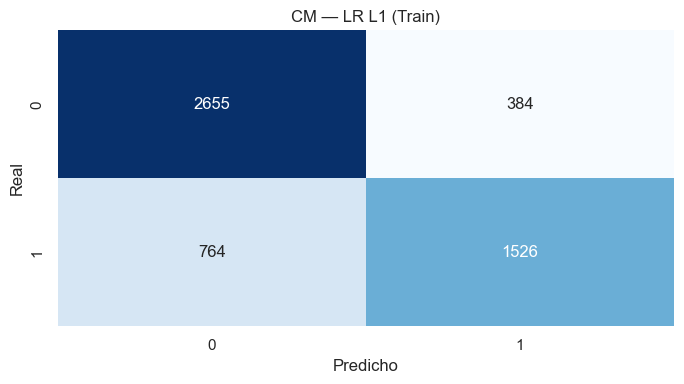


--- LR L1 — Test ---
Accuracy: 0.763
F1-score: 0.698
              precision    recall  f1-score   support

           0      0.758     0.857     0.805      1303
           1      0.771     0.637     0.698       981

    accuracy                          0.763      2284
   macro avg      0.764     0.747     0.751      2284
weighted avg      0.764     0.763     0.759      2284



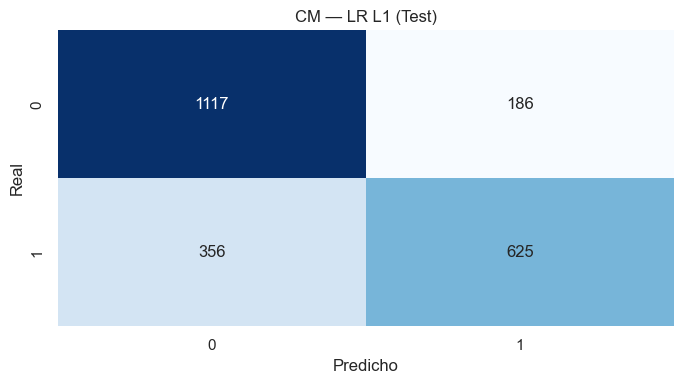


Resumen F1 — L1: train=0.7267  test=0.6975


In [14]:
Cs = [0.001, 0.01, 0.1, 1, 3, 10, 30, 100]
best_l1, best_params_l1, best_cv_l1 = tune_logistic_C(
    X_train_bow, y_train,
    penalty='l1', solver='liblinear',
    Cs=Cs, cv=5, random_state=RANDOM_STATE, n_jobs=-1, return_df=False
)

print("Mejor L1 params:", best_params_l1, " — F1 CV:", round(best_cv_l1, 4))

yhat_tr_l1 = best_l1.predict(X_train_bow)
yhat_te_l1 = best_l1.predict(X_test_bow)

f1_tr_l1 = f1_score(y_train, yhat_tr_l1)
f1_te_l1 = f1_score(y_test,  yhat_te_l1)

report_classification(y_train, yhat_tr_l1, title="LR L1 — Train")
plot_confusion(y_train, yhat_tr_l1, title="CM — LR L1 (Train)")

report_classification(y_test,  yhat_te_l1, title="LR L1 — Test")
plot_confusion(y_test,  yhat_te_l1, title="CM — LR L1 (Test)")

print(f"\nResumen F1 — L1: train={f1_tr_l1:.4f}  test={f1_te_l1:.4f}")


3.3) L2 con selección de C (Código)

Mejor L2 params: {'C': 3}  — F1 CV: 0.6828

--- LR L2 — Train ---
Accuracy: 0.784
F1-score: 0.726
              precision    recall  f1-score   support

           0      0.776     0.873     0.821      3039
           1      0.797     0.666     0.726      2290

    accuracy                          0.784      5329
   macro avg      0.787     0.769     0.773      5329
weighted avg      0.785     0.784     0.780      5329



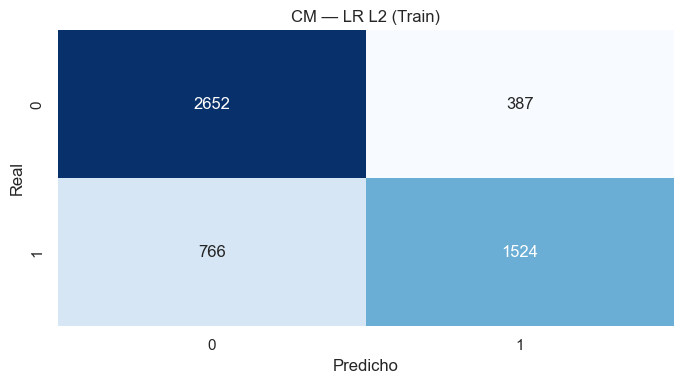


--- LR L2 — Test ---
Accuracy: 0.761
F1-score: 0.697
              precision    recall  f1-score   support

           0      0.758     0.854     0.803      1303
           1      0.767     0.638     0.697       981

    accuracy                          0.761      2284
   macro avg      0.763     0.746     0.750      2284
weighted avg      0.762     0.761     0.758      2284



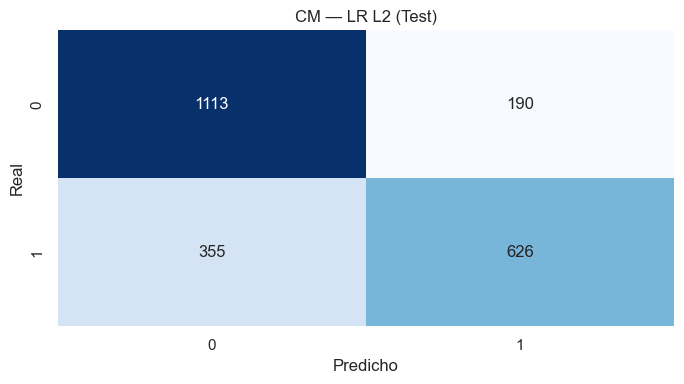


Resumen F1 — L2: train=0.7255  test=0.6967


In [15]:
best_l2, best_params_l2, best_cv_l2 = tune_logistic_C(
    X_train_bow, y_train,
    penalty='l2', solver='liblinear',
    Cs=Cs, cv=5, random_state=RANDOM_STATE, n_jobs=-1, return_df=False
)

print("Mejor L2 params:", best_params_l2, " — F1 CV:", round(best_cv_l2, 4))

yhat_tr_l2 = best_l2.predict(X_train_bow)
yhat_te_l2 = best_l2.predict(X_test_bow)

f1_tr_l2 = f1_score(y_train, yhat_tr_l2)
f1_te_l2 = f1_score(y_test,  yhat_te_l2)

report_classification(y_train, yhat_tr_l2, title="LR L2 — Train")
plot_confusion(y_train, yhat_tr_l2, title="CM — LR L2 (Train)")

report_classification(y_test,  yhat_te_l2, title="LR L2 — Test")
plot_confusion(y_test,  yhat_te_l2, title="CM — LR L2 (Test)")

print(f"\nResumen F1 — L2: train={f1_tr_l2:.4f}  test={f1_te_l2:.4f}")


3.4) Comparación y diagnóstico (Markdown + Código)

**Diagnóstico:**  
- Si `F1_train >> F1_test` en LR sin reg → **overfitting**. Regularización (L1/L2) debe reducir la brecha.  
- Si ambos F1 son bajos → **underfitting** (features o modelo insuficiente).  
- Escogemos el **mejor por F1 en test**.


In [16]:
cmp_lr = pd.DataFrame({
    'modelo': ['LR sin reg', 'LR L1 (best C)', 'LR L2 (best C)'],
    'F1_train': [f1_tr_none, f1_tr_l1, f1_tr_l2],
    'F1_test':  [f1_te_none, f1_te_l1, f1_te_l2]
}).sort_values('F1_test', ascending=False).reset_index(drop=True)

cmp_lr


,modelo,F1_train,F1_test
0,LR sin reg,0.725985,0.697623
1,LR L1 (best C),0.726667,0.697545
2,LR L2 (best C),0.725542,0.696717


3.5) Palabras más importantes (L1) (Código)

In [17]:
coef = best_l1.coef_.ravel()
feat = vectorizer.get_feature_names_out()

top_pos_idx = np.argsort(coef)[-20:][::-1]  # más asociadas a target=1
top_neg_idx = np.argsort(coef)[:20]         # más asociadas a target=0

top_pos = pd.DataFrame({'word': feat[top_pos_idx], 'coef': coef[top_pos_idx]})
top_neg = pd.DataFrame({'word': feat[top_neg_idx], 'coef': coef[top_neg_idx]})

display(top_pos.style.set_caption("Top 20 palabras (+) → asoc. a desastre"))
display(top_neg.style.set_caption("Top 20 palabras (−) → asoc. a no desastre"))


,word,coef
0,spill,4.855387
1,debris,3.991775
2,bomber,3.885009
3,hiroshima,3.747060
4,wildfire,3.478275
5,northern,2.954906
6,earthquake,2.847963
7,mh370,2.845381
8,severe,2.789290
9,bombing,2.666484


,word,coef
0,wrecked,-2.073257
1,bag,-2.059480
2,love,-1.834304
3,full,-1.827790
4,as,-1.788121
5,free,-1.734156
6,put,-1.707869
7,job,-1.443342
8,bloody,-1.433940
9,he,-1.368493


## 5) Bernoulli Naive Bayes (from scratch, α=1) (Markdown)

### Bernoulli Naive Bayes — α=1

**Modelo:**  
- Features binarios {0,1} (BoW binario).  
- *Laplace smoothing:* \(\hat{p}_{jk} = \frac{\#(x_j=1|y=k) + \alpha}{n_k + 2\alpha}\).  
- Métrica de evaluación: **F1** en train/test (como en LR).


Código (clase + evaluación)

In [18]:
class BernoulliNBFromScratch:
    """
    Bernoulli Naive Bayes para features {0,1} con Laplace (alpha).
    Implementación eficiente con matrices dispersas.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes_ = None
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.feature_log_negprob_ = None

    def fit(self, X, y):
        from scipy import sparse
        X = X.tocsr() if sparse.issparse(X) else np.asarray(X)
        self.classes_, counts = np.unique(y, return_counts=True)
        n_samples, n_features = X.shape

        # Priors
        self.class_log_prior_ = np.log(counts / n_samples)

        # Condicionales con Laplace
        feature_prob = np.zeros((len(self.classes_), n_features), dtype=float)
        for idx, k in enumerate(self.classes_):
            rows = np.where(y == k)[0]
            Xk = X[rows]
            ones = (np.asarray(Xk.sum(axis=0)).ravel()
                    if sparse.issparse(Xk) else Xk.sum(axis=0))
            n_k = len(rows)
            p = (ones + self.alpha) / (n_k + 2*self.alpha)
            feature_prob[idx, :] = p

        self.feature_log_prob_ = np.log(feature_prob)
        self.feature_log_negprob_ = np.log(1 - feature_prob)
        return self

    def predict_log_proba(self, X):
        from scipy import sparse
        X = X.tocsr() if sparse.issparse(X) else np.asarray(X)
        J = np.zeros((X.shape[0], len(self.classes_)), dtype=float)
        for idx in range(len(self.classes_)):
            logp = self.feature_log_prob_[idx, :]
            logq = self.feature_log_negprob_[idx, :]
            # x@(logp-logq) + sum(logq)
            part = (X.dot((logp - logq)) + logq.sum()) if sparse.issparse(X) else (X @ (logp - logq) + logq.sum())
            J[:, idx] = self.class_log_prior_[idx] + part
        return J

    def predict(self, X):
        log_J = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_J, axis=1)]


--- BernoulliNB — Train ---
Accuracy: 0.769
F1-score: 0.704
              precision    recall  f1-score   support

           0      0.761     0.867     0.811      3039
           1      0.783     0.640     0.704      2290

    accuracy                          0.769      5329
   macro avg      0.772     0.753     0.758      5329
weighted avg      0.771     0.769     0.765      5329



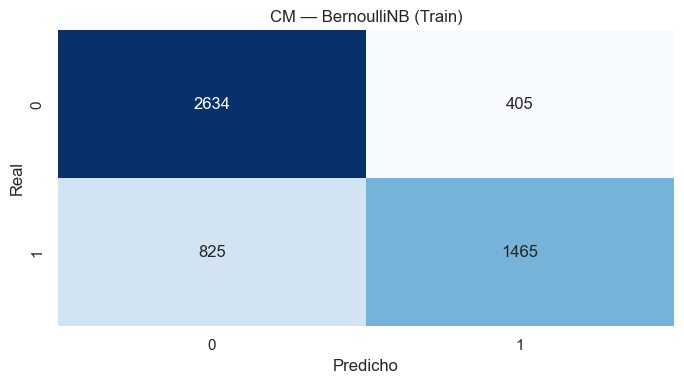


--- BernoulliNB — Test ---
Accuracy: 0.750
F1-score: 0.682
              precision    recall  f1-score   support

           0      0.749     0.847     0.795      1303
           1      0.753     0.623     0.682       981

    accuracy                          0.750      2284
   macro avg      0.751     0.735     0.738      2284
weighted avg      0.751     0.750     0.746      2284



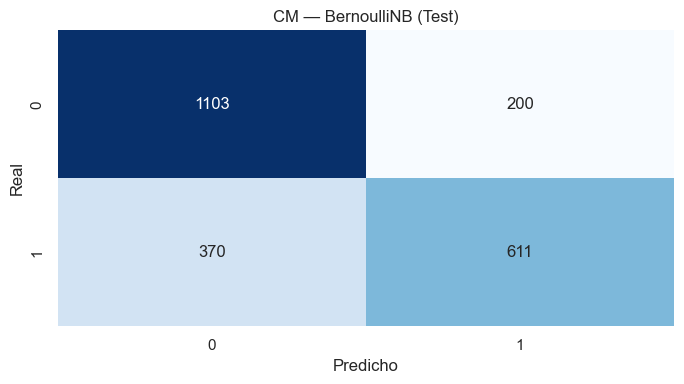


Resumen F1 — NB: train=0.7043  test=0.6819


In [19]:
# Entrenar y evaluar NB
nb = BernoulliNBFromScratch(alpha=1.0).fit(X_train_bow, y_train)
yhat_tr_nb = nb.predict(X_train_bow)
yhat_te_nb = nb.predict(X_test_bow)

f1_tr_nb = f1_score(y_train, yhat_tr_nb)
f1_te_nb = f1_score(y_test,  yhat_te_nb)

report_classification(y_train, yhat_tr_nb, title="BernoulliNB — Train")
plot_confusion(y_train, yhat_tr_nb, title="CM — BernoulliNB (Train)")

report_classification(y_test,  yhat_te_nb, title="BernoulliNB — Test")
plot_confusion(y_test,  yhat_te_nb, title="CM — BernoulliNB (Test)")

print(f"\nResumen F1 — NB: train={f1_tr_nb:.4f}  test={f1_te_nb:.4f}")

## 6) N-grams (2-gramas): vocab, 10 ejemplos y modelos (Markdown)

### N-grams (2-gramas)

- `CountVectorizer(ngram_range=(2,2), binary=True, min_df=M2)`.  
- **M2** con mismo criterio robusto: `M2 = max(2, ceil(0.005 * n_docs_train))`.  
- Reportar tamaño del vocabulario; imprimir **10 2-gramas**.  
- Entrenar **LR (una especificación; usamos L2 + CV)** y **Bernoulli NB** sobre 2-gramas.  
- Comparar F1 (train/test) vs BoW unigramas.


Código

In [20]:
M2 = max(2, ceil(0.005 * len(X_train_clean)))

vectorizer_2g = CountVectorizer(binary=True, ngram_range=(2,2), min_df=M2)
X_train_2g = vectorizer_2g.fit_transform(X_train_clean)
X_test_2g  = vectorizer_2g.transform(X_test_clean)

vocab_2g = vectorizer_2g.get_feature_names_out()
print("Tamaño del vocabulario (2-gramas):", len(vocab_2g))



Tamaño del vocabulario (2-gramas): 7


In [21]:

# 10 ejemplos de 2-gramas
k = min(10, len(vocab_2g))
ejemplos = np.random.choice(vocab_2g, size=k, replace=False) if k > 0 else []
print("Ejemplos (10):", ejemplos)


Ejemplos (10): ['body bag' 'burning building' 'oil spill' 'cross body' 'look like'
 'gon na' 'suicide bomber']


Mejor L2 (2g): {'C': 0.1}  — F1 CV: 0.0798

--- LR L2 (2-gramas) — Train ---
Accuracy: 0.585
F1-score: 0.080
              precision    recall  f1-score   support

           0      0.579     0.995     0.732      3039
           1      0.857     0.042     0.080      2290

    accuracy                          0.585      5329
   macro avg      0.718     0.518     0.406      5329
weighted avg      0.699     0.585     0.452      5329



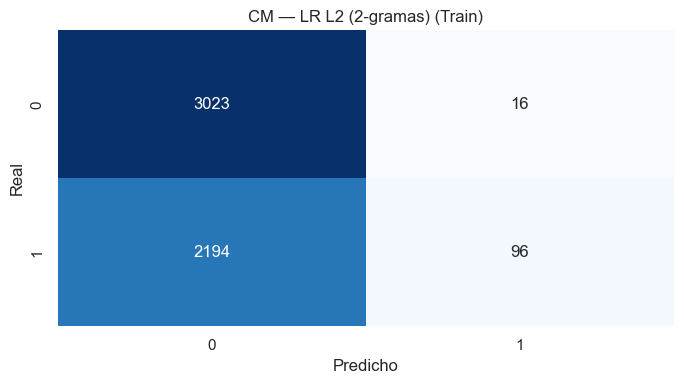


--- LR L2 (2-gramas) — Test ---
Accuracy: 0.581
F1-score: 0.065
              precision    recall  f1-score   support

           0      0.577     0.994     0.730      1303
           1      0.805     0.034     0.065       981

    accuracy                          0.581      2284
   macro avg      0.691     0.514     0.397      2284
weighted avg      0.675     0.581     0.444      2284



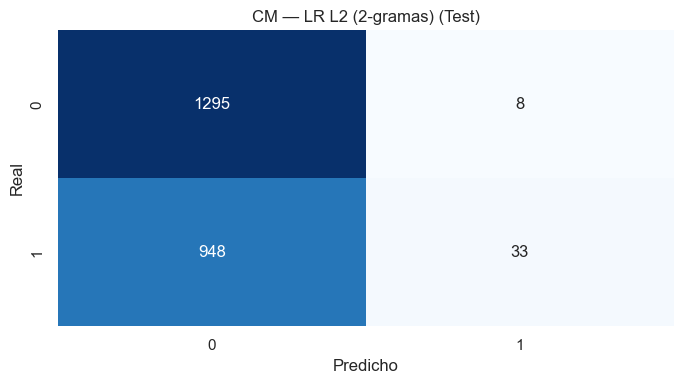

In [22]:
# LR L2 + CV en 2-gramas
best_l2_2g, params_l2_2g, cv_l2_2g = tune_logistic_C(
    X_train_2g, y_train, penalty='l2', solver='liblinear',
    Cs=Cs, cv=5, random_state=RANDOM_STATE, n_jobs=-1, return_df=False
)
print("Mejor L2 (2g):", params_l2_2g, " — F1 CV:", round(cv_l2_2g, 4))

yhat_tr_l2_2g = best_l2_2g.predict(X_train_2g)
yhat_te_l2_2g = best_l2_2g.predict(X_test_2g)

f1_tr_l2_2g = f1_score(y_train, yhat_tr_l2_2g)
f1_te_l2_2g = f1_score(y_test,  yhat_te_l2_2g)

report_classification(y_train, yhat_tr_l2_2g, title="LR L2 (2-gramas) — Train")
plot_confusion(y_train, yhat_tr_l2_2g, title="CM — LR L2 (2-gramas) (Train)")

report_classification(y_test,  yhat_te_l2_2g, title="LR L2 (2-gramas) — Test")
plot_confusion(y_test,  yhat_te_l2_2g, title="CM — LR L2 (2-gramas) (Test)")



--- BernoulliNB (2-gramas) — Train ---
Accuracy: 0.585
F1-score: 0.080
              precision    recall  f1-score   support

           0      0.579     0.995     0.732      3039
           1      0.857     0.042     0.080      2290

    accuracy                          0.585      5329
   macro avg      0.718     0.518     0.406      5329
weighted avg      0.699     0.585     0.452      5329



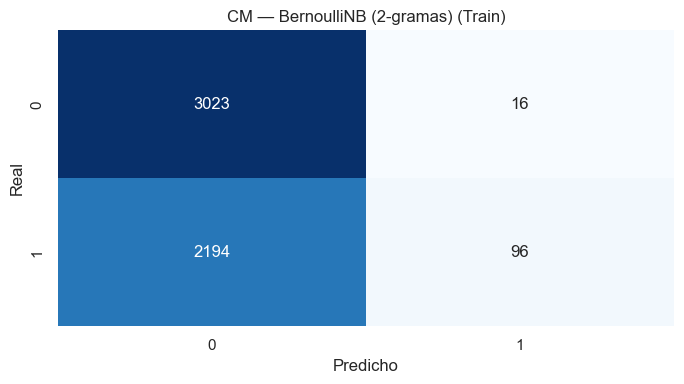


--- BernoulliNB (2-gramas) — Test ---
Accuracy: 0.581
F1-score: 0.065
              precision    recall  f1-score   support

           0      0.577     0.994     0.730      1303
           1      0.805     0.034     0.065       981

    accuracy                          0.581      2284
   macro avg      0.691     0.514     0.397      2284
weighted avg      0.675     0.581     0.444      2284



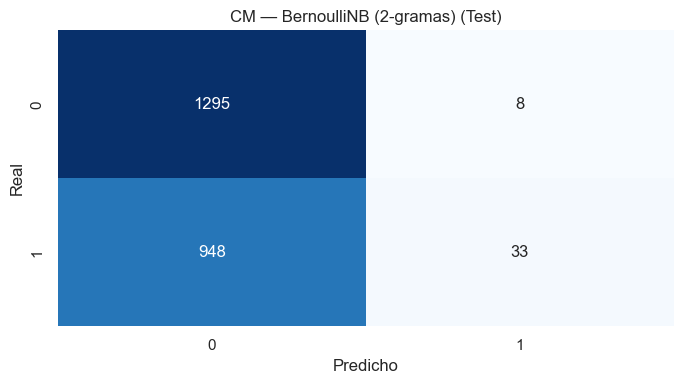


Resumen F1 — LR L2 (2g): train=0.0799  test=0.0646
Resumen F1 — NB (2g):     train=0.0799  test=0.0646


In [23]:
# NB en 2-gramas
nb_2g = BernoulliNBFromScratch(alpha=1.0).fit(X_train_2g, y_train)
yhat_tr_nb_2g = nb_2g.predict(X_train_2g)
yhat_te_nb_2g = nb_2g.predict(X_test_2g)

f1_tr_nb_2g = f1_score(y_train, yhat_tr_nb_2g)
f1_te_nb_2g = f1_score(y_test,  yhat_te_nb_2g)

report_classification(y_train, yhat_tr_nb_2g, title="BernoulliNB (2-gramas) — Train")
plot_confusion(y_train, yhat_tr_nb_2g, title="CM — BernoulliNB (2-gramas) (Train)")

report_classification(y_test,  yhat_te_nb_2g, title="BernoulliNB (2-gramas) — Test")
plot_confusion(y_test,  yhat_te_nb_2g, title="CM — BernoulliNB (2-gramas) (Test)")

print(f"\nResumen F1 — LR L2 (2g): train={f1_tr_l2_2g:.4f}  test={f1_te_l2_2g:.4f}")
print(f"Resumen F1 — NB (2g):     train={f1_tr_nb_2g:.4f}  test={f1_te_nb_2g:.4f}")

## 7) Comparación final y conclusiones (Markdown + Código)

## 6) Comparación final y conclusiones (Parte A)

- Comparamos F1 (train/test) de:
  - **LR** (sin/L1/L2) con **BoW** (unigramas).
  - **NB** con **BoW** (unigramas).
  - **LR L2** y **NB** con **2-gramas**.

**Discusión esperada:**
- Los **2-gramas** capturan contexto (“forest fire”, “flash flood”); pueden mejorar en test si `min_df` controla la dimensionalidad.  
- **Regularización (L1/L2)**: reduce sobreajuste; L1 además da **interpretabilidad** (palabras clave).  
- **NB** puede ser competitivo con BoW binario por su sesgo de independencia; LR suele ganar si hay correlaciones útiles entre términos.

Al final, se elige el **mejor por F1 en test** y se justifican decisiones.


In [24]:
resumen = pd.DataFrame({
    'modelo': [
        'LR sin reg (BoW)', 'LR L1 (BoW)', 'LR L2 (BoW)',
        'NB (BoW)', 'LR L2 (2g)', 'NB (2g)'
    ],
    'F1_train': [
        f1_tr_none, f1_tr_l1, f1_tr_l2,
        f1_tr_nb,   f1_tr_l2_2g, f1_tr_nb_2g
    ],
    'F1_test': [
        f1_te_none, f1_te_l1, f1_te_l2,
        f1_te_nb,   f1_te_l2_2g, f1_te_nb_2g
    ]
}).sort_values('F1_test', ascending=False).reset_index(drop=True)

resumen


,modelo,F1_train,F1_test
0,LR sin reg (BoW),0.725985,0.697623
1,LR L1 (BoW),0.726667,0.697545
2,LR L2 (BoW),0.725542,0.696717
3,NB (BoW),0.704327,0.681920
4,LR L2 (2g),0.079933,0.064579
5,NB (2g),0.079933,0.064579
